# Best Practices for Model Evaluation and Hyperparameter Tuning

### Key Points:-
1. Assess the performance of machine learning models
2. Diagnose the common problems of machine learning algorithms
3. Fine-tune machine learning models
4. Evaluate predictive models using different performance metrics

# Streamlining workflows with pipelines
There is a `Pipeline` class in scikit-learn, which allows us
to fit a model including an arbitrary number of transformation steps and apply it to make predictions
about new data.

## Loading the Breast Cancer Wisconsin dataset

The Breast Cancer Wisconsin dataset contains 569 examples of malignant and benign tumor cells. The first two columns in the dataset store the unique ID
numbers of the examples and the corresponding diagnoses (M = malignant, B = benign), respectively.
Columns 3-32 contain 30 real-valued features that have been computed from digitized images of the
cell nuclei, which can be used to build a model to predict whether a tumor is benign or malignant.

In [1]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                            'machine-learning-databases'
                            '/breast-cancer-wisconsin/wdbc.data', header=None)

# if the Breast Cancer dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df = pd.read_csv('wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
df.shape

(569, 32)

<hr>

In [3]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [4]:
le.transform(['M', 'B'])

array([1, 0])

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

<br>
<br>

## Combining transformers and estimators in a pipeline
Instead of going through the model fitting and data transformation steps for the training and test
datasets separately, we can chain the StandardScaler, PCA, and LogisticRegression objects in a
pipeline

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression())

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.956


<br>
<br>

# Using k-fold cross validation to assess model performance

The common cross-validation techniques `holdout cross-validation`
and `k-fold cross-validation`, which can help us to obtain reliable estimates of the model’s generalization
performance, that is, how well the model performs on unseen data.

...

## The holdout method
A better way of using the holdout method for model selection is to separate the data into three parts:
`a training dataset, a validation dataset, and a test dataset`. The training dataset is used to fit the different models, and the performance on the validation dataset is then used for model selection.

we use the validation dataset to repeatedly
evaluate the performance of the model after training using different hyperparameter values. Once
we are satisfied with the tuning of hyperparameter values, we estimate the model’s generalization
performance on the test dataset

A disadvantage of the holdout method is that the performance estimate may be very sensitive to how
we partition the training dataset into the training and validation subsets; the estimate will vary for
different examples of the data.

<br>
<br>

## K-fold cross-validation
In k-fold cross-validation, we randomly split the training dataset into k folds without replacement.
Here, k–1 folds, the so-called training folds, are used for the model training, and one fold, the so-called
test fold, is used for performance evaluation. This procedure is repeated k times so that we obtain k
models and performance estimates.

We then calculate the average performance of the models based on the different, independent test
folds to obtain a performance estimate that is less sensitive to the sub-partitioning of the training data
compared to the holdout method.

Once we have found satisfactory hyperparameter values, we can retrain the model on the complete
training dataset and obtain a final performance estimate using the independent test dataset.

#### Optimal value of k
- A good standard value for k in k-fold cross-validation is `10`, as empirical evidence shows. For instance,
experiments by Ron Kohavi on various real-world datasets suggest that 10-fold cross-validation offers
the best tradeoff between bias and variance 

- However, if we are working with relatively small training sets, it can be useful to increase the number
of folds.

- A special case of k-fold cross-validation is the `leave-one-out cross-validation (LOOCV)`
method. In LOOCV, we set the number of folds equal to the number of training examples
(k=n) so that only one training example is used for testing during each iteration, which
is a recommended approach for working with very small datasets.

A slight improvement over the standard k-fold cross-validation approach is stratified k-fold cross-val-
idation, which can yield better bias and variance estimates, especially in cases of unequal class proportions.

In stratified cross-validation, the class label proportions are preserved in each fold to ensure
that each fold is representative of the class proportions in the training dataset

In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
    

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)

    print(f'Fold: {k+1:02d}, '
        f'Class distr.: {np.bincount(y_train[train])}, '
        f'Acc.: {score:.3f}')
    
mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'\nCV accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')

Fold: 01, Class distr.: [256 153], Acc.: 0.935
Fold: 02, Class distr.: [256 153], Acc.: 0.935
Fold: 03, Class distr.: [256 153], Acc.: 0.957
Fold: 04, Class distr.: [256 153], Acc.: 0.957
Fold: 05, Class distr.: [256 153], Acc.: 0.935
Fold: 06, Class distr.: [257 153], Acc.: 0.956
Fold: 07, Class distr.: [257 153], Acc.: 0.978
Fold: 08, Class distr.: [257 153], Acc.: 0.933
Fold: 09, Class distr.: [257 153], Acc.: 0.956
Fold: 10, Class distr.: [257 153], Acc.: 0.956

CV accuracy: 0.950 +/- 0.014


In [8]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print(f'CV accuracy scores: {scores}')
print(f'CV accuracy: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


An extremely useful feature of the cross_val_score approach is that we can distribute the evaluation of the different folds across multiple central processing units (CPUs) on our machine.

By setting `n_jobs = -1`, we can use
all available CPUs on our machine to do the computation in parallel

<br>
<br>

# Debugging algorithms with learning curves

we will take a look at two very simple yet powerful diagnostic tools that can help us to
improve the performance of a learning algorithm: `learning curves` and `validation curves`.

## Diagnosing bias and variance problems with learning curves
By
plotting the model training and validation accuracies as functions of the training dataset size, we can
easily detect whether the model suffers from high variance or high bias, and whether the collection
of more data could help to address this problem.

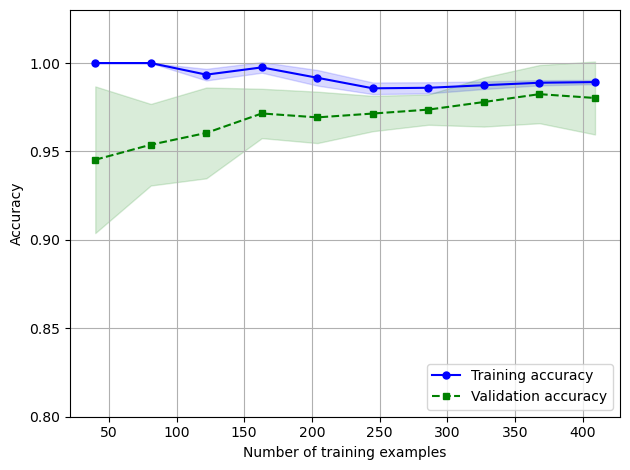

In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', max_iter=10000))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                                X=X_train,
                                y=y_train,
                                train_sizes=np.linspace(0.1, 1.0, 10),
                                cv=10,
                                n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
        color='blue', marker='o',
        markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='Validation accuracy')

plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

As we can see in the preceding learning curve plot, our model performs quite well on both the training
and validation datasets if it has seen more than 250 examples during training. We can also see that the
training accuracy increases for training datasets with fewer than 250 examples, and the gap between
validation and training accuracy widens—an indicator of an increasing degree of overfitting.

<br>
<br>

## Addressing over- and underfitting with validation curves
Validation curves are related to learning curves, but instead of plotting
the training and test accuracies as functions of the sample size, we vary the values of the model parameters, for example, the inverse regularization parameter, C, in logistic regression.

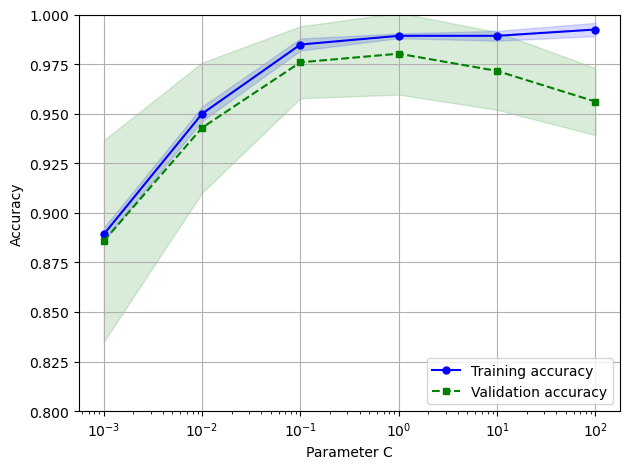

In [10]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
        color='blue', marker='o', 
        markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                train_mean - train_std, alpha=0.15,
                color='blue')

plt.plot(param_range, test_mean, 
        color='green', linestyle='--', 
        marker='s', markersize=5, 
        label='Validation accuracy')

plt.fill_between(param_range, 
                test_mean + test_std,
                test_mean - test_std, 
                alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

Although the differences in the accuracy for varying values of C are subtle, we can see that the model
slightly underfits the data when we increase the regularization strength (small values of C). However,
for large values of C, it means lowering the strength of regularization, so the model tends to slightly
overfit the data. In this case, the sweet spot appears to be between 0.1 and 1.0 of the C value.

<br>
<br>

# Fine-tuning machine learning models via grid search

In machine learning, we have two types of parameters: those that are learned from the training data,
for example, the weights in logistic regression, and the parameters of a learning algorithm that are optimized separately. The latter are the tuning parameters (or `hyperparameters`) of a model, for example,
the regularization parameter in logistic regression or the maximum depth parameter of a decision tree.

we will take a look at a popular hyperparameter optimization technique called `grid search`, which can further help to improve the performance of a model
by finding the optimal combination of hyperparameter values

## Tuning hyperparameters via grid search 

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                        SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
            'svc__kernel': ['linear']},
            {'svc__C': param_range, 
            'svc__gamma': param_range, 
            'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                param_grid=param_grid, 
                scoring='accuracy', 
                refit=True,
                cv=10,
                n_jobs=-1)

gs = gs.fit(X_train, y_train)
print("Best Score:", gs.best_score_)
print("Best Hyperparameters:", gs.best_params_)

Best Score: 0.9846859903381642
Best Hyperparameters: {'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [12]:
clf = gs.best_estimator_

# clf.fit(X_train, y_train) 
# note that we do not need to refit the classifier
# because this is done automatically via refit=True.

print(f'Test accuracy: {clf.score(X_test, y_test):.3f}')

Test accuracy: 0.974


# Exploring hyperparameter configurations more widely with randomized search

- Since grid search is an exhaustive search, it is guaranteed to find the optimal hyperparameter configuration if it is contained in the user-specified parameter grid. However, specifying large hyperparameter
grids makes grid search very expensive in practice.

- An alternative approach for sampling different
parameter combinations is `randomized search`. In randomized search, we draw hyperparameter
configurations randomly from distributions (or discrete sets). In contrast to grid search, randomized
search does not do an exhaustive search over the hyperparameter space. Still, it allows us to explore a
wider range of hyperparameter value settings in a more cost- and time-effective manner.

While RandomizedSearchCV can accept similar discrete lists of values as inputs for the pa-
rameter grid, which is useful when considering categorical hyperparameters, its main power lies in
the fact that we can replace these lists with distributions to sample from.

In [13]:
import scipy.stats


param_range = [0.0001, 0.001, 0.01, 0.1,
                            1.0, 10.0, 100.0, 1000.0]

''' using a loguniform distribution instead of a regular uniform distribution will ensure
that in a sufficiently large number of trials, the same number of samples will be drawn from the
[0.0001, 0.001] range as, for example, the [10.0, 100.0] range '''
param_range = scipy.stats.loguniform(0.0001, 1000.0)

samples = param_range.rvs(10)
print(samples)

[1.65002758e+01 1.85975093e-03 7.30086657e-04 1.64083082e-01
 1.27151610e-03 3.39590780e+01 3.27575620e+01 4.25124711e+01
 1.49310684e-01 4.31908783e-03]


In [14]:
from sklearn.model_selection import RandomizedSearchCV


pipe_svc = make_pipeline(
    StandardScaler(),
    SVC(random_state=1))

param_grid = [{'svc__C': param_range,
                                    'svc__kernel': ['linear']},
                                    {'svc__C': param_range,
                                    'svc__gamma': param_range,
                                    'svc__kernel': ['rbf']}]


rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,
                        n_iter=20,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)

In [15]:
rs = rs.fit(X_train, y_train)
print("Best Score:", rs.best_score_)
print("Best Hyperparameters:", rs.best_params_)

Best Score: 0.9780676328502416
Best Hyperparameters: {'svc__C': 0.05971247755848463, 'svc__kernel': 'linear'}


## More resource-efficient hyperparameter search with successive halving

##### Steps:
1. Draw a large set of candidate configurations via random sampling  
2. Train the models with limited resources, for example, a small subset of the training data (as opposed to using the entire training set)  
3. Discard the bottom 50 percent based on predictive performance  
4. Go back to step 2 with an increased amount of available resources 

The steps are repeated until only one hyperparameter configuration remains.


In [17]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [18]:
hs = HalvingRandomSearchCV(
    pipe_svc,
    param_distributions=param_grid,
    n_candidates='exhaust',
    resource='n_samples',
    factor=1.5,
    random_state=1,
    n_jobs=-1)

- The resource='n_samples' (default) setting specifies that we consider the training set size as the resource we vary between the rounds. 

- Via the factor parameter, we can determine how many candidates
are eliminated in each round. For example, setting factor=2 eliminates half of the candidates, and set-
ting factor=1.5 means that only 100%/1.5 ≈ 66% of the candidates make it into the next round. 

- Instead of choosing a fixed number of iterations as in RandomizedSearchCV, we set n_candidates='exhaust'
(default), which will sample the number of hyperparameter configurations such that the maximum
number of resources (here: training examples) are used in the last round

In [19]:
hs = hs.fit(X_train, y_train)
print("Best Score:", hs.best_score_)
print("Best Parameters:", hs.best_params_)

Best Score: 0.9617647058823529
Best Parameters: {'svc__C': 4.934834261073333, 'svc__kernel': 'linear'}


In [20]:
clf = hs.best_estimator_
print(f'Test accuracy: {hs.score(X_test, y_test):.3f}')

Test accuracy: 0.982


<br>
<br>

## Algorithm selection with nested cross-validation

- If we want to select among different machine
learning algorithms, though, another recommended approach is nested cross-validation. 

- In a nice
study on the bias in error estimation, Sudhir Varma and Richard Simon concluded that the true
error of the estimate is almost unbiased relative to the test dataset when nested cross-validation is
used

In nested cross-validation, we have an outer k-fold cross-validation loop to split the data into training
and test folds, and an inner loop is used to select the model using k-fold cross-validation on the training
fold. After model selection, the test fold is then used to evaluate the model performance. 

we can use the nested cross-validation approach to compare an SVM model to a simple
decision tree classifier; for simplicity, we will only tune its depth parameter

In [24]:
param_range2 = [0.0001, 0.001, 0.01, 0.1,
                            1.0, 10.0, 100.0, 1000.0]
param_grid2 = [{'svc__C': param_range2,
                                    'svc__kernel': ['linear']},
                                    {'svc__C': param_range2,
                                    'svc__gamma': param_range2,
                                    'svc__kernel': ['rbf']}]

In [25]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid2,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(estimator=gs, X=X_train, y=y_train, 
                              scoring='accuracy', cv=5)
print(f'CV accuracy: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV accuracy: 0.974 +/- 0.015


In [26]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                        scoring='accuracy', cv=5)
print(f'CV accuracy: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')

CV accuracy: 0.934 +/- 0.016


As we can see, the nested cross-validation performance of the SVM model (97.4 percent) is notably
better than the performance of the decision tree (93.4 percent), and thus, we’d expect that it might be
the better choice to classify new data that comes from the same population as this particular dataset

<br>
<br>

# Performance evaluation metrics

we evaluated different machine learning models using `prediction accuracy`, which is a useful metric with which to quantify the performance of a model in general.

However, there are several other performance metrics that can be used to measure a model’s relevance,
such as `precision`, `recall`, the `F1 score`, and `Matthews correlation coefficient (MCC)`.

...

## Confusion matrix
A confusion matrix is simply a square matrix that reports the counts of the `true positive (TP)`, `true negative (TN)`, `false positive (FP)`, and `false negative (FN)` predictions of a classifier

In [27]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


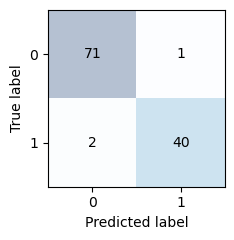

In [28]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

Remember that we previously encoded the class labels so that *malignant* examples are the "postive" class (1), and *benign* examples are the "negative" class (0):

In [29]:
le.transform(['M', 'B'])

array([1, 0])

Note that the (true) class 0 examples that are correctly predicted as class 0 (true negatives) are now in the upper left corner of the matrix (index 0, 0). In order to change the ordering so that the true negatives are in the lower right corner (index 1,1) and the true positves are in the upper left, we can use the `labels` argument like shown below:

In [30]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0])
print(confmat)

[[40  2]
 [ 1 71]]


We conclude:

Assuming that class 1 (malignant) is the positive class in this example, our model correctly classified 71 of the examples that belong to class 0 (true negatives) and 40 examples that belong to class 1 (true positives), respectively. However, our model also incorrectly misclassified 1 example from class 0 as class 1 (false positive), and it predicted that 2 examples are benign although it is a malignant tumor (false negatives).

<br>
<br>

## Optimizing the precision and recall of a classification model

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef

pre_val = precision_score(y_true=y_test, y_pred=y_pred)
print(f'Precision: {pre_val:.3f}')

rec_val = recall_score(y_true=y_test, y_pred=y_pred)
print(f'Recall: {rec_val:.3f}')

f1_val = f1_score(y_true=y_test, y_pred=y_pred)
print(f'F1: {f1_val:.3f}')

mcc_val = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
print(f'MCC: {mcc_val:.3f}')

Precision: 0.976
Recall: 0.952
F1: 0.964
MCC: 0.943


##### MCC
- A measure that summarizes a confusion matrix is the MCC, which is especially popular in
biological research contexts. 
- The MCC ranges between –1 and 1, and it takes all elements
of a confusion matrix into accoun

In [32]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
                                    'svc__kernel': ['linear']},
                                    {'svc__C': c_gamma_range,
                                    'svc__gamma': c_gamma_range,
                                    'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                param_grid=param_grid,
                scoring=scorer,
                cv=10,
                n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


<br>
<br>

## Plotting a receiver operating characteristic

`Receiver operating characteristic (ROC)` graphs are useful tools to select models for classification
based on their performance with respect to the FPR and TPR, which are computed by shifting the
decision threshold of the classifier

we will plot a ROC curve of a classifier that only uses two fea-
tures from the Breast Cancer Wisconsin dataset to predict whether a tumor is benign or malignant.
Although we are going to use the same logistic regression pipeline that we defined previously, we
are only using two features this time. This is to make the classification task more challenging for the
classifier, by withholding useful information contained in the other features, so that the resulting
ROC curve becomes visually more interesting. For similar reasons, we are also reducing the number
of folds in the StratifiedKFold validator to three.

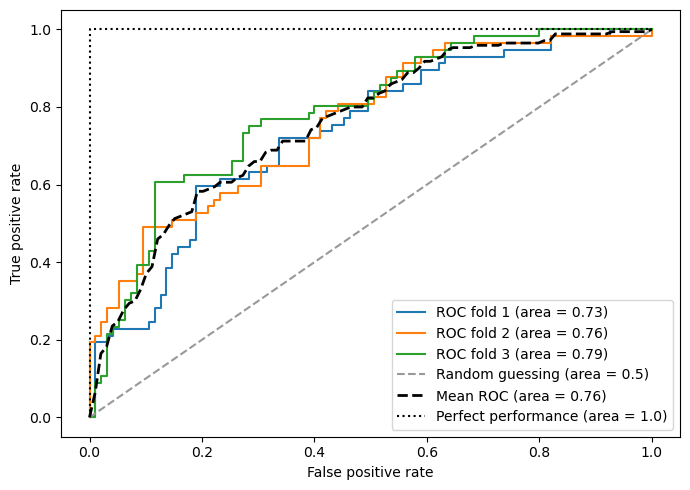

In [34]:
from sklearn.metrics import roc_curve, auc
from numpy import interp


pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                        random_state=1,
                                        solver='lbfgs',
                                        C=100.0))

X_train2 = X_train[:, [4, 14]]


cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
        probas = pipe_lr.fit(X_train2[train],
                                y_train[train]).predict_proba(X_train2[test])

        fpr, tpr, thresholds = roc_curve(y_train[test],
                                                                probas[:, 1],
                                                                pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr,
                tpr,
                label=f'ROC fold {i+1} (area = {roc_auc:.2f})')

plt.plot([0, 1],
        [0, 1],
        linestyle='--',
        color=(0.6, 0.6, 0.6),
        label='Random guessing (area = 0.5)')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--',
        label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)

plt.plot([0, 0, 1],
        [0, 1, 1],
        linestyle=':',
        color='black',
        label='Perfect performance (area = 1.0)')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

We interpolated the average ROC curve from the three folds via the interp function
and calculated the area under the curve via the auc function. The resulting
ROC curve indicates that there is a certain degree of variance between the different folds, and the
average ROC AUC (0.76) falls between a perfect score (1.0) and random guessing (0.5)

<br>
<br>

# Dealing with class imbalance

Class imbalance is a quite common problem when working with real-world data—examples from one class or multiple classes are
over-represented in a dataset. We can think of several domains where this may occur, such as spam
filtering, fraud detection, or screening for diseases.

let’s create an imbalanced
dataset from our dataset, which originally consisted of 357 benign tumors (class 0) and 212 malignant
tumors (class 1)

In [35]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

we took all 357 benign tumor examples and stacked them with the first 40 malignant examples to create a stark class imbalance

One way to deal with imbalanced class proportions during model fitting is to assign a larger penalty
to wrong predictions on the minority class.

Other popular strategies for dealing with class imbalance include upsampling the minority class,
downsampling the majority class, and the generation of synthetic training examples.

We will take the minority class from our imbalanced Breast Cancer Wisconsin dataset (here, class 1) and
repeatedly draw new samples from it until it contains the same number of examples as class label 0

In [37]:
from sklearn.utils import resample

print('Number of class 1 examples before:', X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace=True,
                                    n_samples=X_imb[y_imb == 0].shape[0],
                                    random_state=123)

print('Number of class 1 examples after:', X_upsampled.shape[0])

Number of class 1 examples before: 40
Number of class 1 examples after: 357


In [38]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [39]:
X_bal.shape, y_bal.shape

((714, 30), (714,))

<br>
<br>